In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
from diversity import compression_ratio, homogenization_score, ngram_diversity_score, extract_patterns, get_pos, pos_patterns, token_patterns
import json

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

## Dolly human written responses diversity analysis

In [2]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
personas[2]

'a Spanish-speaking patient with severe myopia interested in LASIK eye surgery'

In [3]:
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')

In [4]:
sample.head()

,index,instruction,num_tokens,num_tokens_round,num_words_round
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,211,210,180
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth",189,190,160
2,109,What is the best way to answer an interview question?,128,130,100
3,37,Write the first paragraph of an advertising brochure describing an hotel nearby the Annecy Lake in France,89,90,60
4,295,"Write an intro to a meetup about music, medicine, and machines",313,310,220


In [5]:
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
sample.head()

,index,instruction,num_tokens,num_tokens_round,num_words_round,response,prompt_id
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,211,210,180,"Dear Mum, I would like to talk to you about the monthly money I get for my studies. I am very grateful that you support me financially during my studies. At the same time, I feel that the current amount is a little bit too low in order to sustain myself. I estimated my monthly expenses and it seems like the money is not enough. We can go through the details if you want. I want to ask you if you can increase the amount so that I can cover my expenses. I understand if you cannot do this or have other reasons against this. However, I want you to know that if you do not increase my monthly money, I will be forced to work part-time next to my studies. There is research that shows that students who work part-time have worse grades than people who do not have to work part-time to afford their studies. I would love to dedicate my full time to my studies to get the best grades and learning outcomes possible; thus, I would prefer not to work part-time. What do you think?",0
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth",189,190,160,"There are several strong arguments against concluding that alien races built the structures like the Stonehenge or the Pyramids. First, there is evidence that these magnificent structures were built by humans. For example, tombs of the pyramid builders were found in the vicinity of the Great Pyramind (with human remains!). The technology to move and assemble the massive stones of the Stonehenge has been shown to be available to humans at that time. Second, given that space is vast the chance of finding one tiny planet among billions is infinitesimal. If alien intelligence had indeed found our one inhabited planet they are unlikely to have just created couple of structures and avoided any further contact with Earth and its inhabitants. In science, Occam’s Razor (“the best explanation is the simplest one”) is a guiding principle and until there is much more evidence of alien visitation it would be inadvisable to jump to a conclusion that aliens built these structures.",1
2,109,What is the best way to answer an interview question?,128,130,100,"The first recommended step is to ask clarifying questions to ensure you understand the question correctly and gather the requirements needed to answer effectively. If it is a mathematical or computer science question, go ahead and work your way through the problem while you verbalize your thought process along the way. If it is a situation question, you should use the STAR method. 1. Situation - set the scene and provide context, 2. Task - describe what was needed to be done and why, 3. Action - explain what action you took, and 4. Result - describe the result of your actions and what you learned from the experience",2
3,37,Write the first paragraph of an advertising brochure describing an hotel nearby the Annecy Lake in France,89,90,60,"This fantastic hotel is ideally located, minutes away from the Annecy Lake, one of the purest in Europe. The water temperature reaches 27 degrees celcius at the peak season, allowing the guests to swim and enjoy several water activities including wake surf and pedalo. Finally, this region is known for being the home of several cheese specialties like ""Raclette"" and ""Tartiflette"" to name a few.",3
4,295,"Write an intro to a meetup about music, medicine, and machines",313,310,220,"Music, Medicine, and Machines\n\nJoin us for an imaginative, authentic, and offbeat networking experience that will advance your knowledge of the technologies that impact the health and well-being of our human condition. To make things interesting (but keep things real), our meetup i

In [6]:
prompts = sample['instruction'].values.tolist()

In [7]:
human_responses = sample['response'].values.tolist()

In [8]:
sample.num_tokens_round.sort_values().tail(5)

95     750
47     780
83     820
72    1440
97    2060
Name: num_tokens_round, dtype: int64

In [9]:
cr = compression_ratio(human_responses, 'gzip')
nds = ngram_diversity_score(human_responses, 4)
joined_pos, tuples = get_pos(human_responses)
ngrams_pos = token_patterns(joined_pos, 5, 10)
cr_pos = compression_ratio(joined_pos, 'gzip')
print(f"CR: {cr}, NDS: {nds}, CR-POS: {cr_pos}")

CR: 2.508, NDS: 3.026, CR-POS: 4.908


## No persona, no cutoff

In [32]:
np_df = pd.read_csv('../output/llama8b-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
np_df['response'] = np_df.response.apply(lambda x: x.strip())
np_df.shape

(100, 2)

In [33]:
np_df['prompt_id'] = [i for i in range(len(prompts))]
np_df.head(3)

,prompt,response,prompt_id
0,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Here's a proposal you can use to convince your mother to increase the amount of money you get every month during your studies:\n\n**Start with a positive tone and appreciation**\n\n""Mom, I wanted to talk to you about my allowance. I really appreciate the support you've been providing me throughout my studies so far. I know that you're always there for me, and I'm grateful for that.""\n\n**Explain your financial situation and needs**\n\n""However, I've been thinking a lot about my expenses, and I feel that the current allowance might not be enough to cover everything I need. As you know, I have to pay for my tuition fees, textbooks, and other study materials. I also need money for transportation, food, and other living expenses. Sometimes, I have to make choices between buying the essentials and saving for the future. I was wondering if we could discuss the possibility of increasing my allowance to help me better manage my finances.""\n\n**Highlight the benefits of a higher allowance**\n\n""If we increase my allowance, I think I'll be able to focus more on my studies and achieve my academic goals. I'll be able to afford the resources I need to succeed, and I'll feel more confident and motivated. Additionally, a higher allowance will help me develop good financial habits and learn how to manage my money effectively. This will benefit me not only during my studies but also in the long run, when I'll be responsible for my own finances.""\n\n**Offer a solution and compromise**\n\n""I was thinking that we could discuss a possible increase of [specific amount] every month. I know that this might require some adjustments, but I'm willing to work hard and earn my keep. I could take on more responsibilities around the house, help with chores, or even get a part-time job to supplement my allowance. I'm open to finding a solution that works for both of us.""\n\n**Show that you're responsible and committed**\n\n""Mom, I want to assure you that I'm committed to my studies and my future. I'm working hard to achieve my goals, and I appreciate your support. I promise to be responsible with the increased allowance and use it wisely. I'll keep you updated on my expenses and finances, and I'll be grateful for your continued guidance and support.""\n\nRemember to have an open and respectful conversation with your mother, and be prepared to listen to her concerns and suggestions. Good luck!",0
1,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","While I understand the intrigue behind the idea of ancient structures being evidence of UFO activities, I strongly disagree with the notion that sites like Stonehenge and the Great Pyramid are proof of extraterrestrial intervention. The overwhelming consensus among archaeologists, historians, and scientists is that these structures were built by the ingenuity and labor of ancient civilizations using the knowledge and tools available to them at the time. The construction of Stonehenge, for example, is now widely attributed to the Neolithic people of Britain, who likely used a combination of astronomical observations and engineering skills to align the stones in a precise manner. Similarly, the Great Pyramid of Giza is believed to have been constructed by the ancient Egyptians using a system of ramps, pulleys, and levers, rather than any extraterrestrial assistance. While the idea of ancient UFO activity may capture our imagination, it is essential to approach such claims with a critical and evidence-based perspective, rather than relying on speculation or unproven theories.",1
2,What is the best way to answer an interview question?,"The best way to answer an interview question involves a structured approach t

In [34]:
np_df['persona_id'] = [-1 for i in range(len(prompts))]
np_df.head(3)

,prompt,response,prompt_id,persona_id
0,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Here's a proposal you can use to convince your mother to increase the amount of money you get every month during your studies:\n\n**Start with a positive tone and appreciation**\n\n""Mom, I wanted to talk to you about my allowance. I really appreciate the support you've been providing me throughout my studies so far. I know that you're always there for me, and I'm grateful for that.""\n\n**Explain your financial situation and needs**\n\n""However, I've been thinking a lot about my expenses, and I feel that the current allowance might not be enough to cover everything I need. As you know, I have to pay for my tuition fees, textbooks, and other study materials. I also need money for transportation, food, and other living expenses. Sometimes, I have to make choices between buying the essentials and saving for the future. I was wondering if we could discuss the possibility of increasing my allowance to help me better manage my finances.""\n\n**Highlight the benefits of a higher allowance**\n\n""If we increase my allowance, I think I'll be able to focus more on my studies and achieve my academic goals. I'll be able to afford the resources I need to succeed, and I'll feel more confident and motivated. Additionally, a higher allowance will help me develop good financial habits and learn how to manage my money effectively. This will benefit me not only during my studies but also in the long run, when I'll be responsible for my own finances.""\n\n**Offer a solution and compromise**\n\n""I was thinking that we could discuss a possible increase of [specific amount] every month. I know that this might require some adjustments, but I'm willing to work hard and earn my keep. I could take on more responsibilities around the house, help with chores, or even get a part-time job to supplement my allowance. I'm open to finding a solution that works for both of us.""\n\n**Show that you're responsible and committed**\n\n""Mom, I want to assure you that I'm committed to my studies and my future. I'm working hard to achieve my goals, and I appreciate your support. I promise to be responsible with the increased allowance and use it wisely. I'll keep you updated on my expenses and finances, and I'll be grateful for your continued guidance and support.""\n\nRemember to have an open and respectful conversation with your mother, and be prepared to listen to her concerns and suggestions. Good luck!",0,-1
1,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","While I understand the intrigue behind the idea of ancient structures being evidence of UFO activities, I strongly disagree with the notion that sites like Stonehenge and the Great Pyramid are proof of extraterrestrial intervention. The overwhelming consensus among archaeologists, historians, and scientists is that these structures were built by the ingenuity and labor of ancient civilizations using the knowledge and tools available to them at the time. The construction of Stonehenge, for example, is now widely attributed to the Neolithic people of Britain, who likely used a combination of astronomical observations and engineering skills to align the stones in a precise manner. Similarly, the Great Pyramid of Giza is believed to have been constructed by the ancient Egyptians using a system of ramps, pulleys, and levers, rather than any extraterrestrial assistance. While the idea of ancient UFO activity may capture our imagination, it is essential to approach such claims with a critical and evidence-based perspective, rather than relying on speculation or unproven theories.",1,-1
2,What is the best way to answer an interview question?,"The best way to answer an interview question involves a stru

## This calculates cr and nds over all prompts *per persona*, and averages over cr for all personas

In [47]:
def calc_cr_nds_over_personas(df):
    crs = []
    ndss = []
    crs_pos = []
    for persona_id in tqdm(df.persona_id.unique()):
        responses = df.loc[df.persona_id==persona_id].drop_duplicates(subset=['prompt_id'])['response'].values.tolist()
        cr = compression_ratio(responses, 'gzip')
        nds = ngram_diversity_score(responses, 4)
        #CR-POS
        joined_pos, tuples = get_pos(responses)
        ngrams_pos = token_patterns(joined_pos, 5, 10)
        cr_pos = compression_ratio(joined_pos, 'gzip')
        crs.append(cr)
        ndss.append(nds)
        crs_pos.append(cr_pos)
    print(f"CR: {np.round(np.mean(crs),2)} ± {np.round(np.std(crs),2)}, NDS: {np.round(np.mean(ndss),2)} ± {np.round(np.std(ndss), 2)}, CR-POS: {np.round(np.mean(crs_pos),2)} ± {np.round(np.std(crs_pos), 2)}")

In [39]:
calc_cr_nds_over_personas(np_df)

CR: 2.78 +- 0.0, NDS: 2.84 +- 0.0, CR-POS: 5.8 +- 0.0


## No persona with cutoff

In [40]:
npc_df = pd.read_csv('../output/llama8b-cutoff-np/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
npc_df['response'] = npc_df.response.apply(lambda x: x.strip())
npc_df['prompt_id'] = [i for i in range(len(prompts))]
npc_df['persona_id'] = [-1 for i in range(len(prompts))]

npc_df.shape

(100, 4)

In [41]:
calc_cr_nds_over_personas(npc_df)

CR: 2.57 +- 0.0, NDS: 3.07 +- 0.0, CR-POS: 5.29 +- 0.0


## Persona, no cutoff

In [44]:
persona_df = pd.read_csv('../output/llama8b-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
persona_df['response'] = persona_df.response.apply(lambda x: x.strip())

persona_ids = []
prompt_ids = []
for persona_id in range(100):
    for prompt_id in range(100):
        persona_ids += [persona_id]
        prompt_ids += [prompt_id]
persona_df['prompt_id'] = prompt_ids
persona_df['persona_id'] = persona_ids

persona_df.head(3)

,prompt,response,prompt_id,persona_id
0,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"As your PR manager, I'd like to present a strategic approach to persuade your mother to consider increasing your monthly allowance.\n\n**Campaign Name:** ""Empowering Education, Enriching Opportunities""\n\n**Objective:** To effectively communicate the value of increasing your monthly allowance, highlighting its positive impact on your academic and personal growth.\n\n**Key Messages:**\n\n1. **Investment in Education:** Emphasize that increasing your allowance will not only support your immediate needs but also foster a sense of responsibility and independence, preparing you for future financial management.\n2. **Academic Excellence:** Explain how a higher allowance will enable you to focus on your studies, potentially leading to better grades and a more successful academic journey.\n3. **Personal Growth:** Highlight the benefits of increased financial freedom, such as exploring extracurricular activities, developing new skills, and building meaningful relationships.\n4. **Future Prospects:** Discuss how a higher allowance will contribute to your long-term goals, including pursuing higher education, career opportunities, and financial stability.\n\n**Strategic Approach:**\n\n1. **Prepare a Compelling Case:** Gather evidence to support your request, such as a detailed breakdown of your expenses, a plan for managing your finances, and examples of how a higher allowance will positively impact your academic and personal growth.\n2. **Choose the Right Time and Place:** Schedule a calm and distraction-free conversation with your mother, ensuring you both have enough time to discuss the matter thoroughly.\n3. **Use 'I' Statements:** Instead of making demands or accusations, express your thoughts and feelings using 'I' statements. For example, ""I feel that my current allowance is too low, and I believe a higher amount would help me focus on my studies and personal growth.""\n4. **Show Appreciation:** Acknowledge your mother's current support and express gratitude for her investment in your education. This will help her feel valued and more receptive to your request.\n5. **Be Flexible and Open-Minded:** Be prepared to negotiate and find a mutually agreeable solution. Your mother may not be able to increase the allowance immediately, but she may be willing to review and adjust it periodically.\n\n**Media Kit:**\n\nTo further support your request, consider creating a media kit that includes:\n\n* A detailed budget breakdown\n* A plan for managing your finances\n* Examples of how a higher allowance will positively impact your academic and personal growth\n* A letter or email outlining your request and the benefits of increasing your allowance\n\n**Press Release:**\n\nCraft a persuasive press release (in this case, a letter to your mother) that highlights the key messages and strategic approach:\n\n""Dear Mother,\n\nI wanted to take a moment to discuss my current allowance and how it affects my academic and personal growth. After careful consideration, I believe that increasing my allowance would have a positive impact on my studies, relationships, and future prospects.\n\nBy investing in my education, I'm confident that I can achieve better grades, explore extracurricular activities, and develop valuable skills. A higher allowance will also enable me to focus on my long-term goals, including pursuing higher education, career opportunities, and financial stability.\n\nI understand that increasing my allowance may require adjustments, but I'm willing to work together to find a mutually agreeab

In [48]:
calc_cr_nds_over_personas(persona_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:16<00:00,  3.77s/it]

CR: 2.91 ± 0.1, NDS: 2.62 ± 0.08, CR-POS: 5.62 ± 0.21


## Persona plus cutoff

In [49]:
personac_df = pd.read_csv('../output/llama8b-cutoff-persona/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')
personac_df['response'] = personac_df.response.apply(lambda x: x.strip())

persona_ids = []
prompt_ids = []
for persona_id in range(100):
    for prompt_id in range(100):
        persona_ids += [persona_id]
        prompt_ids += [prompt_id]
personac_df['prompt_id'] = prompt_ids
personac_df['persona_id'] = persona_ids

personac_df.head(3)

,prompt,response,prompt_id,persona_id
0,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona in 180 words or less:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"I'd be happy to help you craft a persuasive argument, but I have to advise that approaching your mother through a press release might not be the most effective method. However, if we were to create a draft press release, here's a possible approach:\n\n---\n\nFOR IMMEDIATE RELEASE:\n\n""Request for Increased Allowance from Dedicated Student""\n\nDear Mother,\n\nAs you are aware, I have been diligently pursuing my studies and have consistently demonstrated my commitment to academic excellence. Despite my best efforts, I have found it increasingly challenging to manage my finances with the current allowance. I kindly request that we reassess and increase the monthly allowance to better align with the rising costs of living and educational expenses.\n\nI believe this adjustment will enable me to maintain a healthier work-life balance, focus on my studies, and ultimately achieve my academic goals.\n\nThank you for considering my request.\n\nSincerely,\n[Your Name]",0,0
1,"Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona in 160 words or less:\n\nWrite a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","As a spokesperson for a leading organization, I'd like to address the recent claim made by our colleague regarding ancient structures being evidence of UFO activities. While we understand the intrigue surrounding these enigmatic sites, such as Stonehenge and the Great Pyramid, there is no credible evidence to support the notion that they are of extraterrestrial origin. Archaeological and historical research overwhelmingly suggests that these structures were built by ancient civilizations using their own ingenuity, skills, and knowledge. Theories about UFO involvement are speculative and lack concrete evidence, often relying on unverifiable sources and unproven claims. As a responsible and evidence-based organization, we encourage our colleagues and the public to rely on credible sources and scientific consensus when discussing these fascinating sites. By doing so, we can foster a deeper understanding and appreciation of our shared cultural heritage.",1,0
2,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona in 100 words or less:\n\nWhat is the best way to answer an interview question?,"As a PR manager, I emphasize the importance of preparation and clarity when answering interview questions. The best approach is to take a moment to collect your thoughts, then provide a concise and specific response that directly addresses the question. Use the STAR method to structure your answer: Situation, Task, Action, Result. This helps to paint a clear picture of your experience and achievements, while also showcasing your skills and expertise. Additionally, be authentic and confident, and always highlight the key takeaways and outcomes. This will leave a lasting impression on the interviewer.",2,0


In [50]:
calc_cr_nds_over_personas(personac_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:35<00:00,  2.16s/it]

CR: 2.73 ± 0.09, NDS: 2.85 ± 0.08, CR-POS: 5.32 ± 0.25


## Response length distribution

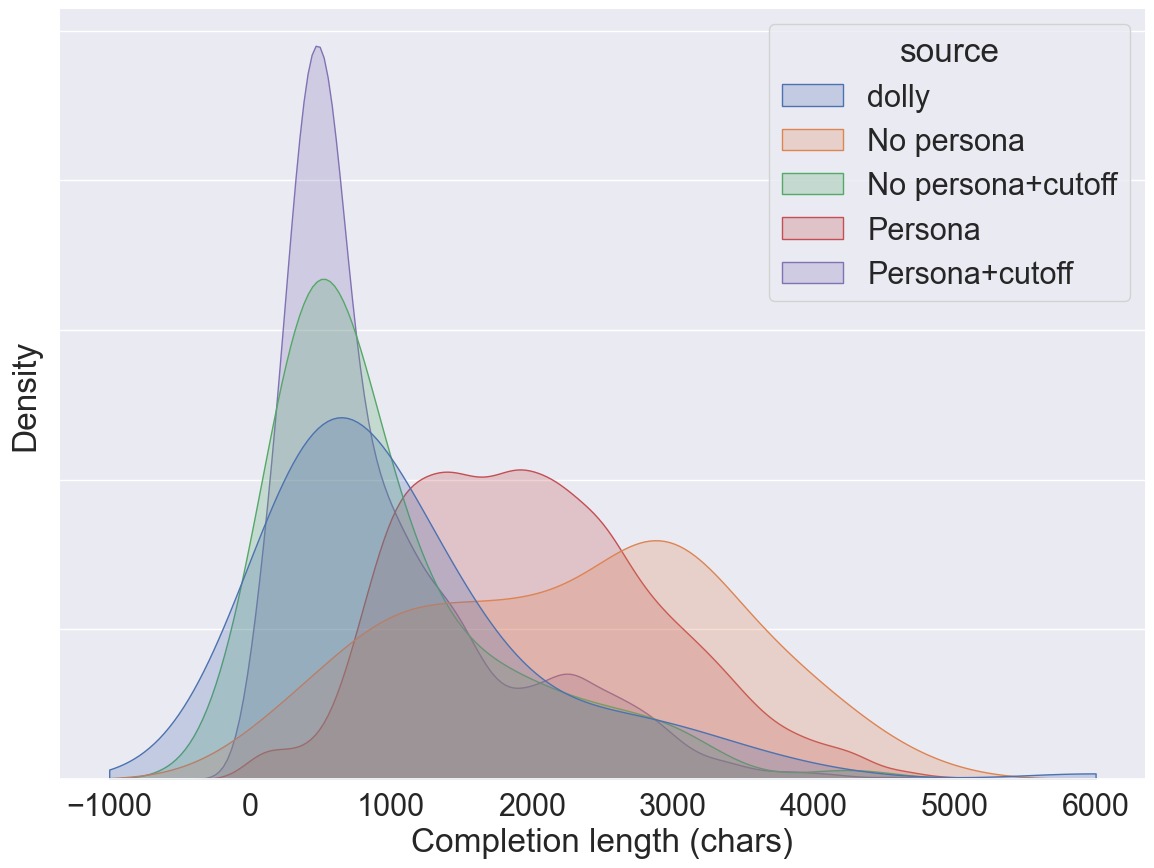

In [57]:
len_df = {'len': [], 'source':[]}

# Load all the human responses first.
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
len_df['source'] += ['dolly' for _ in range(len(sample))]

for (df, source_name) in [(np_df, 'No persona'), (npc_df,'No persona+cutoff'), (persona_df, 'Persona'), (personac_df, 'Persona+cutoff')]:
    len_df['len'] += df['response'].apply(lambda x: len(x)).values.tolist()
    len_df['source'] += [source_name for _ in range(len(df))]
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='source', common_norm=False, fill=True, clip=[-1000,6000])
g.set_xlabel('Completion length (chars)')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

## llama-1b

In [ ]:
llama1b = pd.read_csv('../output/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')
llama1b['persona_id'] = persona_ids
llama1b['prompt_id'] = prompt_ids

In [ ]:
unique_ll_responses = llama1b.drop_duplicates(subset=['persona_id', 'prompt_id'])['response'].values.tolist()

In [ ]:
cr = compression_ratio(unique_ll_responses, 'gzip')
nds = ngram_diversity_score(unique_ll_responses, 4)
print(f"CR: {cr}, NDS: {nds}")

In [ ]:
joined_pos, tuples = get_pos(unique_ll_responses)
ngrams_pos = token_patterns(joined_pos, 5, 10)
ngrams_pos

In [ ]:
cr = compression_ratio(joined_pos, 'gzip')
cr